# MIPS   

TODO:

Nondimensionalize 


# Dependency

In [ ]:
import cupy as cp
!pip show cupy-cuda111

Name: cupy-cuda111
Version: 9.4.0
Summary: CuPy: NumPy & SciPy for GPU
Home-page: https://cupy.dev/
Author: Seiya Tokui
Author-email: tokui@preferred.jp
License: MIT License
Location: /usr/local/lib/python3.7/dist-packages
Requires: fastrlock, numpy
Required-by: 


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from time import time

from numba import jit, njit, prange
from numba.typed import List
from matplotlib.animation import FuncAnimation, PillowWriter

# Utils


In [8]:
@njit()
def set_seed(a):
    np.random.seed(a)

def display(posx, posy):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Now, we draw our points with a gradient of colors.
    ax.scatter(posx[:len(posx)//2], posy[:len(posx)//2], linewidths=0.5,
               marker='o', s=5, facecolors='none', edgecolors='teal', cmap=plt.cm.jet)
    ax.scatter(posx[len(posx)//2:], posy[len(posx)//2:], linewidths=0.5,
            marker='o', s=5, facecolors='none', edgecolors='coral', cmap=plt.cm.jet)

    ax.axis('equal')
    ax.grid()
    # ax.set_axis_off()


def save(file_name, data):
    """ Saves the model to a numpy file.
    """
    print("Writing to " + file_name)
    np.savez_compressed(file_name, **data)


def load(file_name):
    """ Loads the model from numpy file.
    """
    print("Loading from " + file_name)
    return dict(np.load(file_name))

def cal_folding(r, N, Lx, Ly):
    return np.pi * r * r * N / (Lx * Ly)

def cal_Pe(r, v, D):
    t = r**2 / D
    Pe = t * v /r
    return Pe
    
def record_gif(data):
    fig,ax = plt.subplots()
    def animate(i):
        fig.clear()
        line = display(data[i][0],data[i][1])
        ax.set_title("iteration " + str(i))
        return line

    ani = FuncAnimation(fig, animate, interval=200, frames=354)

    ani.save("test0.gif", dpi=200, writer=PillowWriter(fps=24))

def generate_points_with_min_distance(n, shape, min_dist):
  """
      n: number of points
      example:
      generate_points_with_min_distance(n=100, shape=(100,100), min_dist=0.1)
  """
  # compute grid shape based on number of points
  width_ratio = shape[1] / shape[0]
  num_y = np.int32(np.sqrt(n / width_ratio))
  num_x = np.int32(n / num_y)

  # create regularly spaced neurons
  x = np.linspace(0., shape[1], num_x, dtype=np.float32)
  y = np.linspace(0., shape[0], num_y, dtype=np.float32)
  coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

  # compute spacing
  init_dist = np.min((x[1]-x[0], y[1]-y[0]))

  # perturb points
  max_movement = (init_dist - min_dist)/2
  noise = np.random.uniform(low=-max_movement,
                              high=max_movement,
                              size=(len(coords), 2))
  coords += noise

  return coords

# Code Body

In [9]:
NOPYTHON = True

In [21]:
@jit(nopython=NOPYTHON)
def pos_updater(posx, posy, vecx, vecy, theta,
                N, step, v_p, D_r, D_t, gamma):

    # Interaction and Self-drive Motion
    posx += step * (vecx + v_p * np.cos(theta)) / gamma
    posy += step * (vecy + v_p * np.sin(theta)) / gamma

    # Diffusion
    t1 = np.sqrt(2*D_t*step)
    t2 = np.sqrt(2*D_r*step)
    posx += (t1*np.random.randn(N)).astype(np.float32)
    posy += (t1*np.random.randn(N)).astype(np.float32)
    theta += (t2*np.random.randn(N)).astype(np.float32)



@jit(nopython=NOPYTHON)
def LJPotential(x, y, d2, r2, epsilon):
    '''
        calculat the FJ potential
    :param x: difference on x
    :param y: difference on y
    :param d2: squared distance x^2 + y^2
    :param r2: squared of radius of particles r , r^6
    :param epsilon: the potential strength
    :return:
    '''
    rx = x/d2
    ry = y/d2
    k = (r2/d2)**3
    s = epsilon * (k - 2 * k**2)
    return s*rx, s*ry


@jit(nopython=NOPYTHON, parallel=True)
def vec_updater(grid, posx, posy, vecx, vecy,
                M, r2, rm, epsilon):

    r_lower = -2 * rm
    r_upper = 2 * rm
    rm2 = rm**2

    for idx_grid in prange(len(grid)):
      points = grid[idx_grid]
      # Run with numba parallel iteration
      for idx_i in prange(len(points)):
          i = points[idx_i]
          #======================================================
          # Collide Detection
          # get the detection range
          index_range = get_cal_range(grid, idx_grid, M)

          for idx_j in prange(len(index_range)):
              j = index_range[idx_j]
              if i == j: continue
              # check if two particles are contacted, most particle are not contacted
              x1 = posx[i]
              x2 = posx[j]
              x_diff = x1 - x2

              if r_lower < x_diff < r_upper:

                  y1 = posy[i]
                  y2 = posy[j]
                  y_diff = y1 - y2

                  if r_lower < y_diff < r_upper:
                      d2 = x_diff ** 2 + y_diff ** 2 + 1e-16
                      if d2 < rm2:
                          # if contact add the repulsive force
                          vpx, vpy = LJPotential(x_diff, y_diff, d2, r2, epsilon)
                          vecx[i] += vpx
                          vecy[i] += vpy
                          vecx[j] -= vpx
                          vecy[j] -= vpy

@jit(nopython=NOPYTHON, parallel=True)
def interval_seperation(pos, M):
  idx = pos * M  // 1
  grid = List()
  for i in range(M):
    grid.append(np.zeros(1).astype(np.int64))
  # return grid
  for i in prange(M):
    grid[i] = np.where(idx==i)[0]
  return grid

@jit(nopython=NOPYTHON, parallel=True)
def grid_seperation1(grid, posx, posy, M, Lx, Ly):
  M = int(M)
  idx = posx * M // Lx
  idy = posy * M // Ly
  for i in prange(M*M):
    grid[i] = List(np.where((idx==i%M) & (idy==i//M))[0])
  return grid


@jit(nopython=NOPYTHON, parallel=True)
def grid_seperation(grid, posx, posy, M, Lx, Ly):
  '''
    For G(indx, indy), the index is $ind = indy * M + indx$ 
    Get the range in the following grid denoted by O. and skip X
    
            ^
          X X X
    indy  X X X ->
          X X X
          indx
  '''
  M = int(M)
  N = len(posx)
  idx = (posx * M // Lx).astype(np.int64)
  idy = (posy * M // Ly).astype(np.int64)
  lst = [[0] for _ in range(M**2)]
  for i in range(N):
    temp = idy[i]
    # there are M+1 edges but only M grids
    if temp == M: temp=0
    t = np.int64(idx[i] + temp*M)
    lst[t].append(np.int64(i))
  for i in range(M**2):
    grid[i] = List(lst[i])
  return grid


def grid_init(M):
  grid = List()
  for i in range(M*M):
    grid.append(List(np.zeros(1).astype(np.int64)))
  return grid

@jit(nopython=NOPYTHON)
def get_cal_range(grid, ind, M):
  '''
    For G(ind1, ind2)
    Get the range in the following grid denoted by O. and skip X
            ^
          O O O
    indy  X G O ->
          X X X
          indx
  '''
  indx = ind%M
  indy = ind//M
  c = list(grid[ind][1:])
  r = list(grid[(indx+1) % M + indy * M][1:])
  tr = list(grid[(indx+1) % M + ((indy+1) % M) * M][1:])
  t = list(grid[indx + ((indy+1) % M) * M][1:])
  tl = list(grid[(indx-1) % M + ((indy+1) % M) * M][1:])
  return c+r+t+tl+tr


@jit(nopython=NOPYTHON)
def run(grid, posx, posy, vecx, vecy, theta,
        N, M, r2, rm, epsilon, step, v_p, D_r, D_t, gamma, Lx, Ly):
    vec_updater(grid, posx, posy, vecx, vecy,
                M, r2, rm, epsilon)
    pos_updater(posx, posy, vecx, vecy, theta, N, step, v_p, D_r, D_t, gamma)
    posx = np.remainder(posx, Lx).astype(np.float32)
    posy = np.remainder(posy, Ly).astype(np.float32)
    theta = np.remainder(theta, 2 * np.pi).astype(np.float32)
    grid = grid_seperation(grid, posx, posy, M, Lx, Ly)

    return grid, posx, posy, vecx, vecy, theta


# Main Run

In [22]:
def main():
    def init(N):
        coords = generate_points_with_min_distance(n=N, shape=(Lx*0.95, Ly*0.95), min_dist=2*r)
        posx = np.array(coords[:,0])
        posy = np.array(coords[:,1])
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    # Units
    # Length
    r = 1  # radius of particle
    # Energy
    kbT=1e-20
    # time
    t = 1

    # Hyper-parameters
    epoch = int(4e4)

    N = 15000  # number of particles
    M = 80
    Lx = 260 # box size x
    Ly = 260 # box size y
    step = 1e-5
    r2 = r ** 2  # radius of particle power 2
    rm = 2**(1/6) * r # effecient radius
    gamma = 1  # fraction
    F_p = 1e-20    # Self-force
    epsilon = 1  # potential depth times 4
    D_t = r2 / t  # transition diffusion
    D_r = 3 * D_t/r2  # rotation diffusion
    
    v_p =  120 # mean speed
    is_save = True
    is_load = False

    # Initialization
    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)

    if is_load:
        data = load("./results/state1000.npz")
        posx = data['px']
        posy = data['py']
        vecx = data['vx']
        vecy = data['vy']
        theta = data['theta']
        grid = grid_seperation(grid, posx, posy, M, Lx, Ly)
        print("=========Load savepoint successfully=========")
    display(posx, posy)
    plt.show()
    
    # Calculate physical quantities
    print("folding ratio is: ",cal_folding(r,N,Lx,Ly))
    print("Pe value is: ",cal_Pe(r,v_p,D_t))

    # Run
    set_seed(123)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r2, rm, epsilon, step, v_p, D_r, D_t, gamma, Lx, Ly)
        t2 = time()
        vecx = np.array([np.sign(x) if np.abs(x)>100 else x for x in vecx])
        vecy = np.array([np.sign(x) if np.abs(x)>100 else x for x in vecy])

        if _%100==0 or _<100:
            print("iteration: ", _, "time: ", t2-t1) 
        
        if is_save and (_ % 200==0):
            data = {'px': posx,
                    'py': posy,
                    'vx': vecx,
                    'vy': vecy,
                    'theta': theta
                    }
            display(posx, posy)
            plt.show()
            save("./results/state"+str(_)+".npz", data)
    return posx, posy


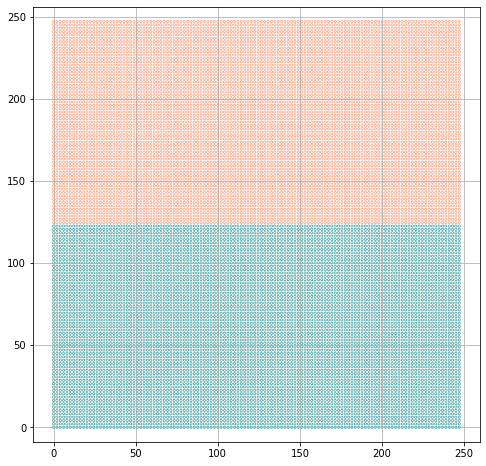

folding ratio is:  0.6970989615953683
Pe value is:  120.0
iteration:  0 time:  5.985347032546997


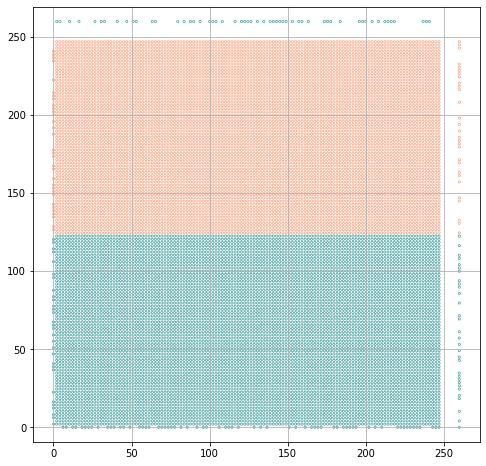

Writing to ./results/state0.npz
iteration:  1 time:  2.304945707321167
iteration:  2 time:  0.06685304641723633
iteration:  3 time:  0.0672295093536377
iteration:  4 time:  0.06563186645507812
iteration:  5 time:  0.06685566902160645
iteration:  6 time:  0.07000017166137695
iteration:  7 time:  0.0657036304473877
iteration:  8 time:  0.07300066947937012
iteration:  9 time:  0.06580400466918945
iteration:  10 time:  0.06571674346923828
iteration:  11 time:  0.06542301177978516
iteration:  12 time:  0.0656120777130127
iteration:  13 time:  0.06669116020202637
iteration:  14 time:  0.06703591346740723
iteration:  15 time:  0.06663370132446289
iteration:  16 time:  0.07099771499633789
iteration:  17 time:  0.06479215621948242
iteration:  18 time:  0.06547665596008301
iteration:  19 time:  0.06994485855102539
iteration:  20 time:  0.0677039623260498
iteration:  21 time:  0.0648183822631836
iteration:  22 time:  0.07499980926513672
iteration:  23 time:  0.06820964813232422
iteration:  24 tim

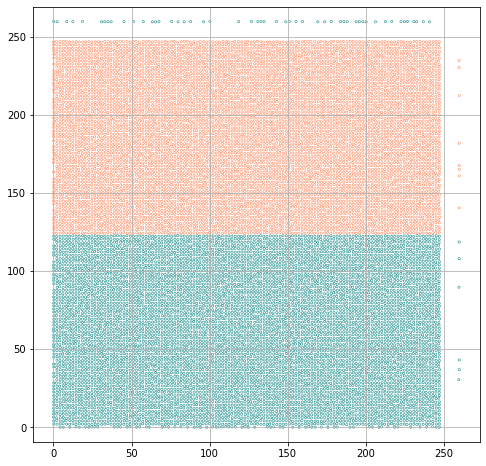

Writing to ./results/state200.npz
iteration:  300 time:  0.07000064849853516
iteration:  400 time:  0.06987214088439941


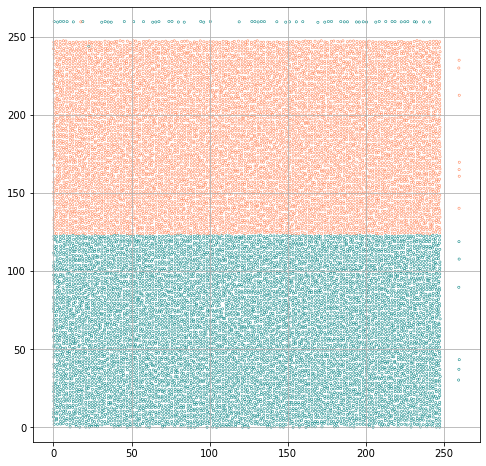

Writing to ./results/state400.npz


In [23]:
result = main()

In [ ]:
display(result[0], result[1])

# Function tests

(10000, 2)


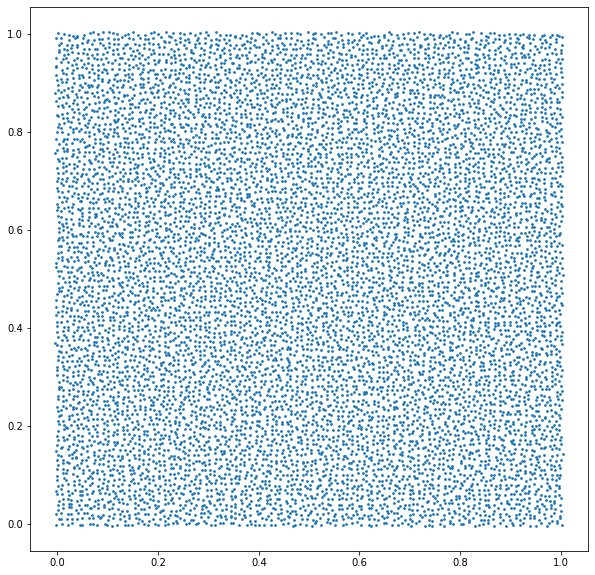

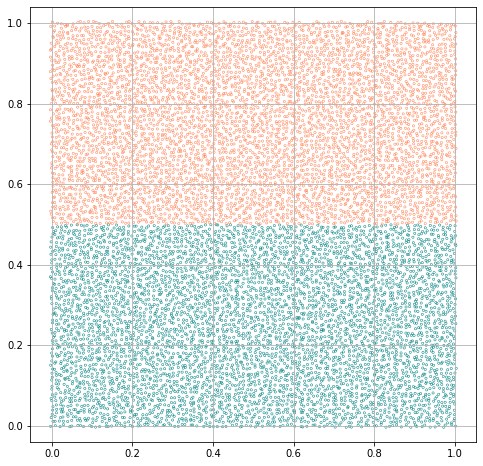

In [5]:
# Test Display
coords = generate_points_with_min_distance(n=10000, shape=(1,1), min_dist=0.002)
print(coords.shape)
plt.figure(figsize=(10,10))
plt.scatter(coords[:,0], coords[:,1], s=3)
display(coords[:,0], coords[:,1])

(10000, 2)


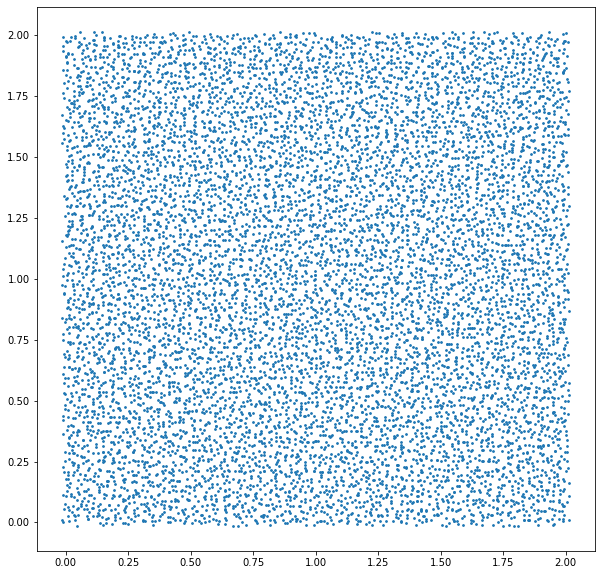

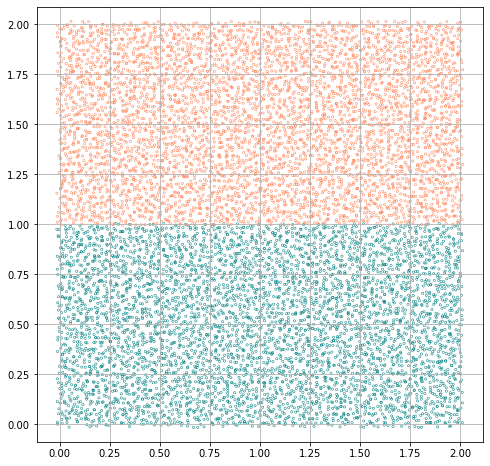

In [6]:
coords = generate_points_with_min_distance(n=10000, shape=(2,2), min_dist=0.05)
print(coords.shape)
plt.figure(figsize=(10,10))
plt.scatter(coords[:,0], coords[:,1], s=3)
display(coords[:,0], coords[:,1])

(0.0, 2.0)

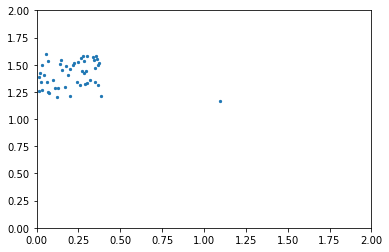

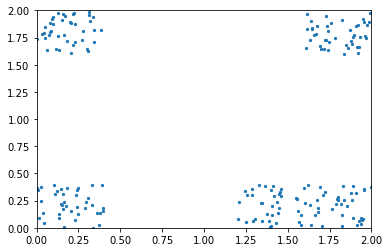

In [5]:
Lx = Ly = 2
M = 5
tempx = np.arange(0,2,0.002)
tempy = np.arange(0,2,0.002)
np.random.shuffle(tempy)
np.random.shuffle(tempx)

# intervals = interval_seperation(tempx,5)
# print(repr(intervals))
# print(repr(intervals[0]))
grid = grid_init(5)
grid = grid_seperation(grid, tempx,tempy,M, Lx, Ly)
mask=grid[15]
plt.scatter(tempx[mask],tempy[mask],s=5)
plt.xlim(0,Lx)
plt.ylim(0,Ly)
# print(repr(grid))

mask = get_cal_range(grid, 24,M)
# print(repr(mask))
plt.figure()
plt.scatter(tempx[mask],tempy[mask],s=5)
plt.xlim(0,Lx)
plt.ylim(0,Ly)


# Hyperparameters

Fine tuned hyperparameters.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

attr_args = AttrDict()
hyperparameters = {
    'seed': 0,
    'N' : 10,  # number of particles
    'M' : 10,
    'step' : 1e-4,
    'epoch' : 3000,
    'r' : r,
    'r2' : r ** 2,
    'rm' : 2**(1/6) * r,
    'gamma' : 1,  # fraction
    'epsilon' : 1e-15,  # potential depth times 4
    'v_p' : 1,  # mean speed
    'D_t' : 0,  # transition diffusion
    'D_r' : 0,  # rotation diffusion
    'is_save' : False,
    'is_load' : False,
    }
attr_args.update(hyperparameters)

# Tests

Collision transportation, need at least one step.

Speed update when two particle contact.

iid Gaussian

## Test0 - Movement test

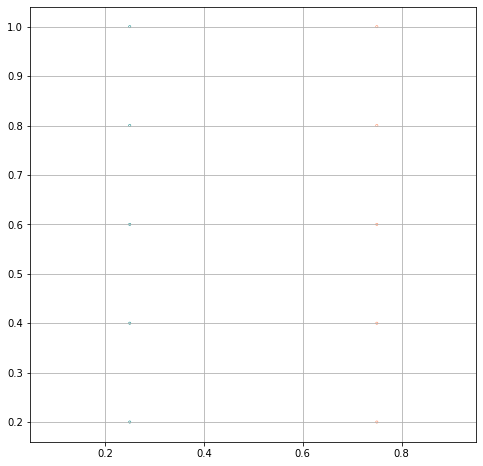

folding ratio is:  0.00019634954084936208
iteration:  0 time:  7.2690112590789795


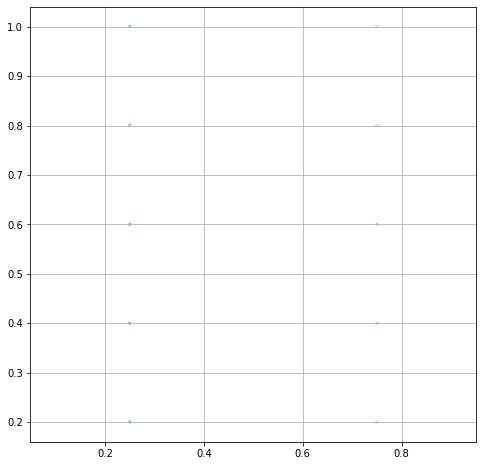

iteration:  1 time:  4.256509304046631
iteration:  2 time:  0.0
iteration:  3 time:  0.0
iteration:  4 time:  0.0
iteration:  5 time:  0.0
iteration:  6 time:  0.008061647415161133
iteration:  7 time:  0.0
iteration:  8 time:  0.0
iteration:  9 time:  0.0
iteration:  10 time:  0.0
iteration:  11 time:  0.0
iteration:  12 time:  0.0
iteration:  13 time:  0.0
iteration:  14 time:  0.0
iteration:  15 time:  0.0
iteration:  16 time:  0.0
iteration:  17 time:  0.0
iteration:  18 time:  0.0
iteration:  19 time:  0.0
iteration:  20 time:  0.008003711700439453
iteration:  21 time:  0.0
iteration:  22 time:  0.0
iteration:  23 time:  0.0
iteration:  24 time:  0.0
iteration:  25 time:  0.0
iteration:  26 time:  0.0
iteration:  27 time:  0.0
iteration:  28 time:  0.0
iteration:  29 time:  0.0
iteration:  30 time:  0.0
iteration:  31 time:  0.0
iteration:  32 time:  0.0
iteration:  33 time:  0.0
iteration:  34 time:  0.0
iteration:  35 time:  0.008067846298217773
iteration:  36 time:  0.0008525848

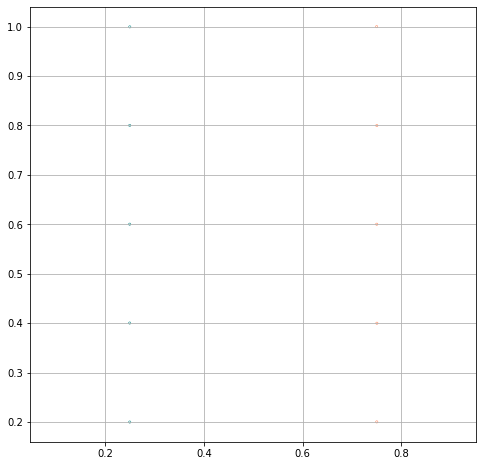

In [12]:
def test0():
    def init(N):
        posx = np.concatenate((np.ones(N//2)*0.25,np.ones(N//2)*0.75))
        posy = np.concatenate((np.linspace(0.2,1,N//2),np.linspace(0.2,1,N//2)))
        theta = np.concatenate((np.ones(N//2)*0,np.ones(N//2)*np.pi))
        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 10  # number of particles
    M = 2
    Lx = 400 # box size x
    Ly = 400 # box size y
    step = 1e-6
    epoch = int(1e2)
    r = 1  # radius of particle
    r2 = r ** 2  # radius of particle power 2
    rm = 2**(1/6) * r # effecient radius
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-4  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3 * D_t/r2  # rotation diffusion
    is_save = True
    is_load = False

    # Initialization
    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)

    if is_load:
        data = load("./results/state.npz")
        posx = data['px']
        posy = data['py']
        vecx = data['vx']
        vecy = data['vy']
        theta = data['theta']
        grid = grid_seperation(grid, posx, posy, M)
        print("=========Load savepoint successfully=========")
    display(posx, posy)
    plt.show()
    
    # Calculate physical quantities
    print("folding ratio is: ",cal_folding(r,N,Lx,Ly))

    # Run
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r2, rm, epsilon, step, v_p, D_r, D_t, gamma, Lx, Ly)
        t2 = time()
        
        if _%100==0 or _<50:
            print("iteration: ", _, "time: ", t2-t1) 
        
        if is_save and (_ % 200==0):
            data = {'px': posx,
                    'py': posy,
                    'vx': vecx,
                    'vy': vecy,
                    'theta': theta
                    }
            display(posx, posy)
            plt.show()
            # save("./results/state"+str(_)+".npz", data)
    display(posx, posy)
test0()

## Test1 - Collision test

Test if the diffusion is too strong, initialize all the particles in a line

iteration:  0 time:  0.0009932518005371094
iteration:  1 time:  0.003996133804321289
iteration:  2 time:  0.002999544143676758
iteration:  3 time:  0.004003047943115234
iteration:  4 time:  0.003979206085205078
iteration:  5 time:  0.00400090217590332
iteration:  6 time:  0.004000186920166016
iteration:  7 time:  0.004057168960571289
iteration:  8 time:  0.003942966461181641
iteration:  9 time:  0.0029990673065185547
iteration:  10 time:  0.003999471664428711
iteration:  11 time:  0.004088878631591797
iteration:  12 time:  0.00399470329284668
iteration:  13 time:  0.004001140594482422
iteration:  14 time:  0.003998279571533203
iteration:  15 time:  0.003920316696166992
iteration:  16 time:  0.004996776580810547
iteration:  17 time:  0.0029981136322021484
iteration:  18 time:  0.0029997825622558594
iteration:  19 time:  0.003608226776123047
iteration:  20 time:  0.00500035285949707
iteration:  21 time:  0.003998279571533203
iteration:  22 time:  0.0030002593994140625
iteration:  23 time

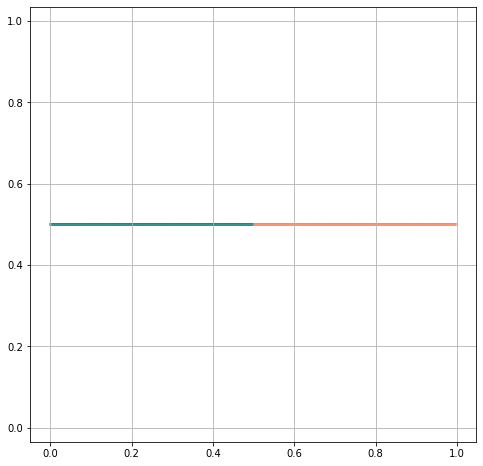

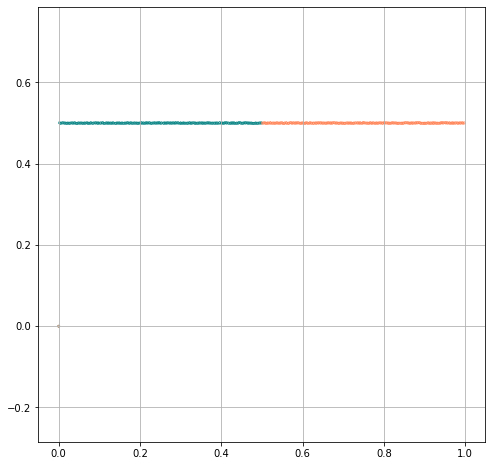

In [9]:
def test1():
    def init(N):
        posx = np.linspace(0, 1, N)
        posy = np.ones(N)/2
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 500  # number of particles
    M = 10
    step = 1e-6
    epoch = 1000
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-3  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)

test1()

## Test2

iteration:  0 time:  0.0009634494781494141
iteration:  1 time:  0.004998683929443359
iteration:  2 time:  0.006002902984619141
iteration:  3 time:  0.004995822906494141
iteration:  4 time:  0.005000591278076172
iteration:  5 time:  0.004999637603759766
iteration:  6 time:  0.004998922348022461
iteration:  7 time:  0.004998922348022461
iteration:  8 time:  0.005001068115234375
iteration:  9 time:  0.005000114440917969
iteration:  10 time:  0.005000114440917969
iteration:  11 time:  0.0059986114501953125
iteration:  12 time:  0.0050008296966552734
iteration:  13 time:  0.00599980354309082
iteration:  14 time:  0.004999876022338867
iteration:  15 time:  0.00600123405456543
iteration:  16 time:  0.004998445510864258
iteration:  17 time:  0.005000114440917969
iteration:  18 time:  0.005998849868774414
iteration:  19 time:  0.0050008296966552734
iteration:  20 time:  0.005002021789550781
iteration:  21 time:  0.006998538970947266
iteration:  22 time:  0.004999876022338867
iteration:  23 time

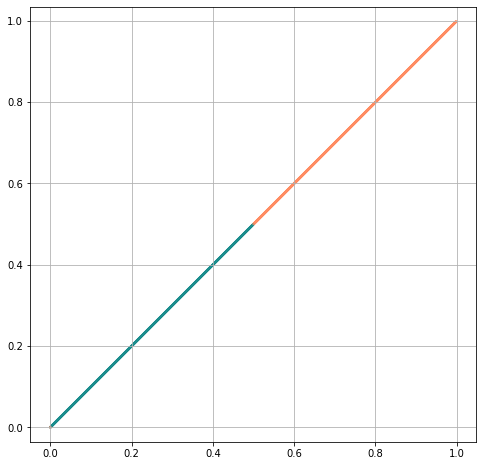

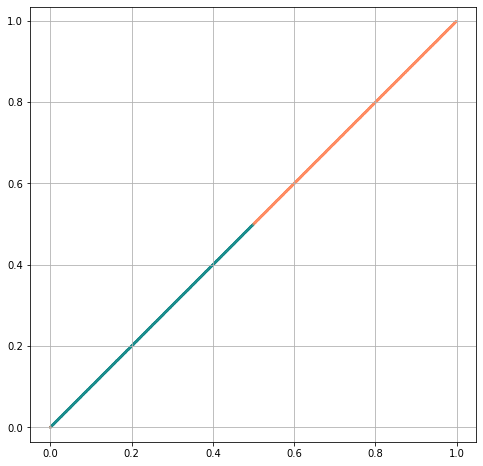

In [18]:
def test2():
    @njit()
    def init(N):
        posx = np.linspace(0, 1, N)
        posy = np.linspace(0, 1, N)
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 800  # number of particles
    M = 10
    step = 1e-7
    epoch = 1000
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-3  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)
test2()

## Test3

Test the effect of diffusion in Uniform Distribution

In [4]:
def test3():
    def init(N):
        coords = generate_points_with_min_distance(n=N, shape=(1,1), min_dist=2*r)
        posx = np.array(coords[:,0])
        posy = np.array(coords[:,1])
        theta = np.random.randn(N)
        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 40000  # number of particles
    step = 3e-2
    epoch = 1
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 0  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    display(posx, posy)
    for _ in range(epoch):
        # print("iteration: ", _)
        run(posx, posy, vecx, vecy, theta,
            N, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)

test3()